In [1]:
import pandas as pd
import seaborn as sns
import seaborn.objects as so
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier, NearestNeighbors
from sklearn.model_selection import LeaveOneOut
from sklearn.cluster import KMeans, DBSCAN
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn import linear_model 
from sklearn.metrics import mean_squared_error, r2_score 

import logging
import os

"""
# Estas dos lineas son para silenciar las advertencias de TensorFlow
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
logging.getLogger('tensorflow').setLevel(logging.ERROR)
"""

import tensorflow as tf
import keras
#from tf_regressor import train_test_split_scale_center

/opt/miniconda3/envs/alc/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
2024-07-02 18:10:13.411399: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-07-02 18:10:16.002099: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-07-02 18:10:24.209649: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-07-02 18:10:30.251412: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
data_raw = pd.read_csv("FBRef2020-21.csv")

In [3]:
data_proc = (data_raw.query("Min >= 500")
             .drop(columns = [column for column in data_raw.columns if data_raw[column].isna().sum() > 100]))

display(data_proc[data_proc.isna().sum(axis=1) != 0])

display(data_proc.loc[313].isna().sum())
display(data_proc.loc[1190].isna().sum())
display(data_proc.loc[2525].isna().sum())
display(data_proc.loc[2525].isna().sort_values())


data_proc = data_proc.drop(index=[313,1190,2525]).reset_index()

,Player,Nation,Pos,Squad,Comp,Age,Born,MP,Starts,Min,...,PrgDistCarry/90,ProgCarry/90,CarryIntoThird/90,CarryIntoBox/90,Miscontrol/90,Dispossessed/90,PassTarget/90,PassesReceived/90,PassRec%,ProgPassReceived/90
313,Salvador Ferrer,es ESP,DF,Spezia,it Serie A,22.0,1998.0,18,14,1190,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1190,Jota,pt POR,FW,Valladolid,es La Liga,21.0,1999.0,17,7,668,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2525,Martín Zubimendi,es ESP,MF,Real Sociedad,es La Liga,21.0,1999.0,31,17,1882,...,131.4,4.74,1.44,0.05,0.33,0.72,43.9,42.5,96.8,0.86


95

95

2

Player                 False
Att 3rdPress/90        False
Mid 3rdPress/90        False
Def 3rdPress/90        False
SuccPress/90           False
                       ...  
MedAtt/90              False
FKPassAtt/90           False
ProgPassReceived/90    False
ErrToShot/90            True
Clearances/90           True
Name: 2525, Length: 119, dtype: bool

In [4]:
data_num = data_proc.drop(columns = [col for col in data_proc.columns if data_proc[col].dtype not in ['float64','int64']])
data_num = data_num.drop(columns = data_num.columns.tolist()[:data_num.columns.tolist().index('Ast/90')])



## Clustering

### Graficos con variables aleatorias

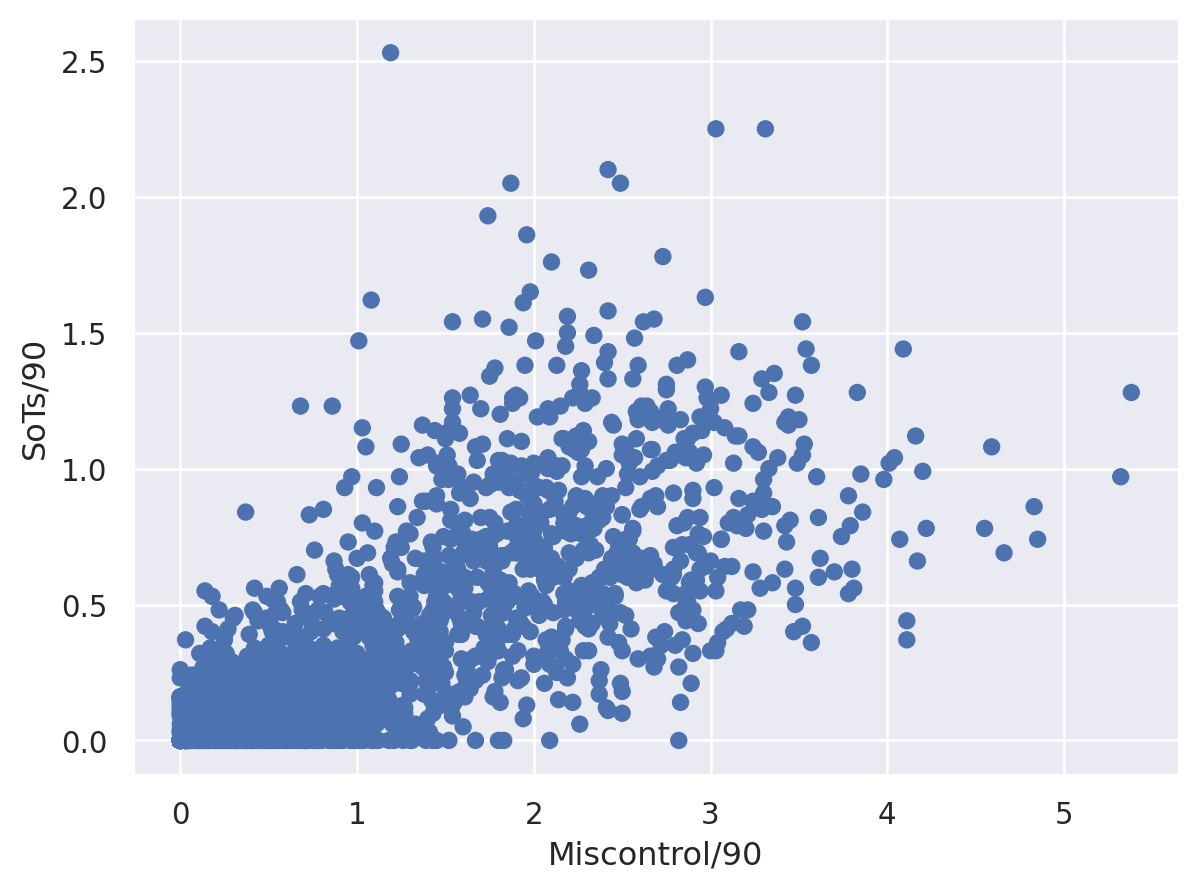

In [5]:
data_procesada = data_num.drop(columns=[col for col in data_num.columns if col not in ["Miscontrol/90","SoTs/90"]])
(
    so.Plot(data= data_procesada, x= "Miscontrol/90", y= "SoTs/90")
    .add(so.Dot())
)

En el gráfico anterior, no es posible hallar a simple vista grupos distintos de datos. Podríamos decir que en el área de mayor densidad cerca del origen hay un grupo que se distingue de un grupo alejado del origen cuyos puntos no forman una gran densidad, pero no es fácil verlo a simple vista.

### PCA

Realizamos un análisis de componentes principales para hacer clustering y analizar los resultados.

In [184]:
X_star = MinMaxScaler((0,1)).set_output(transform="pandas").fit_transform(data_num)

X_star_t = np.transpose(X_star)
N = len(X_star)
Sigma = (X_star_t @ X_star) / N


In [185]:
gamma, U = np.linalg.eigh(Sigma)

gamma_flip = np.flip(gamma)
U = np.flip(U, 1)

Z = X_star @ U 
Z.columns = ["Z" + str(i) for i in range(1,104)]

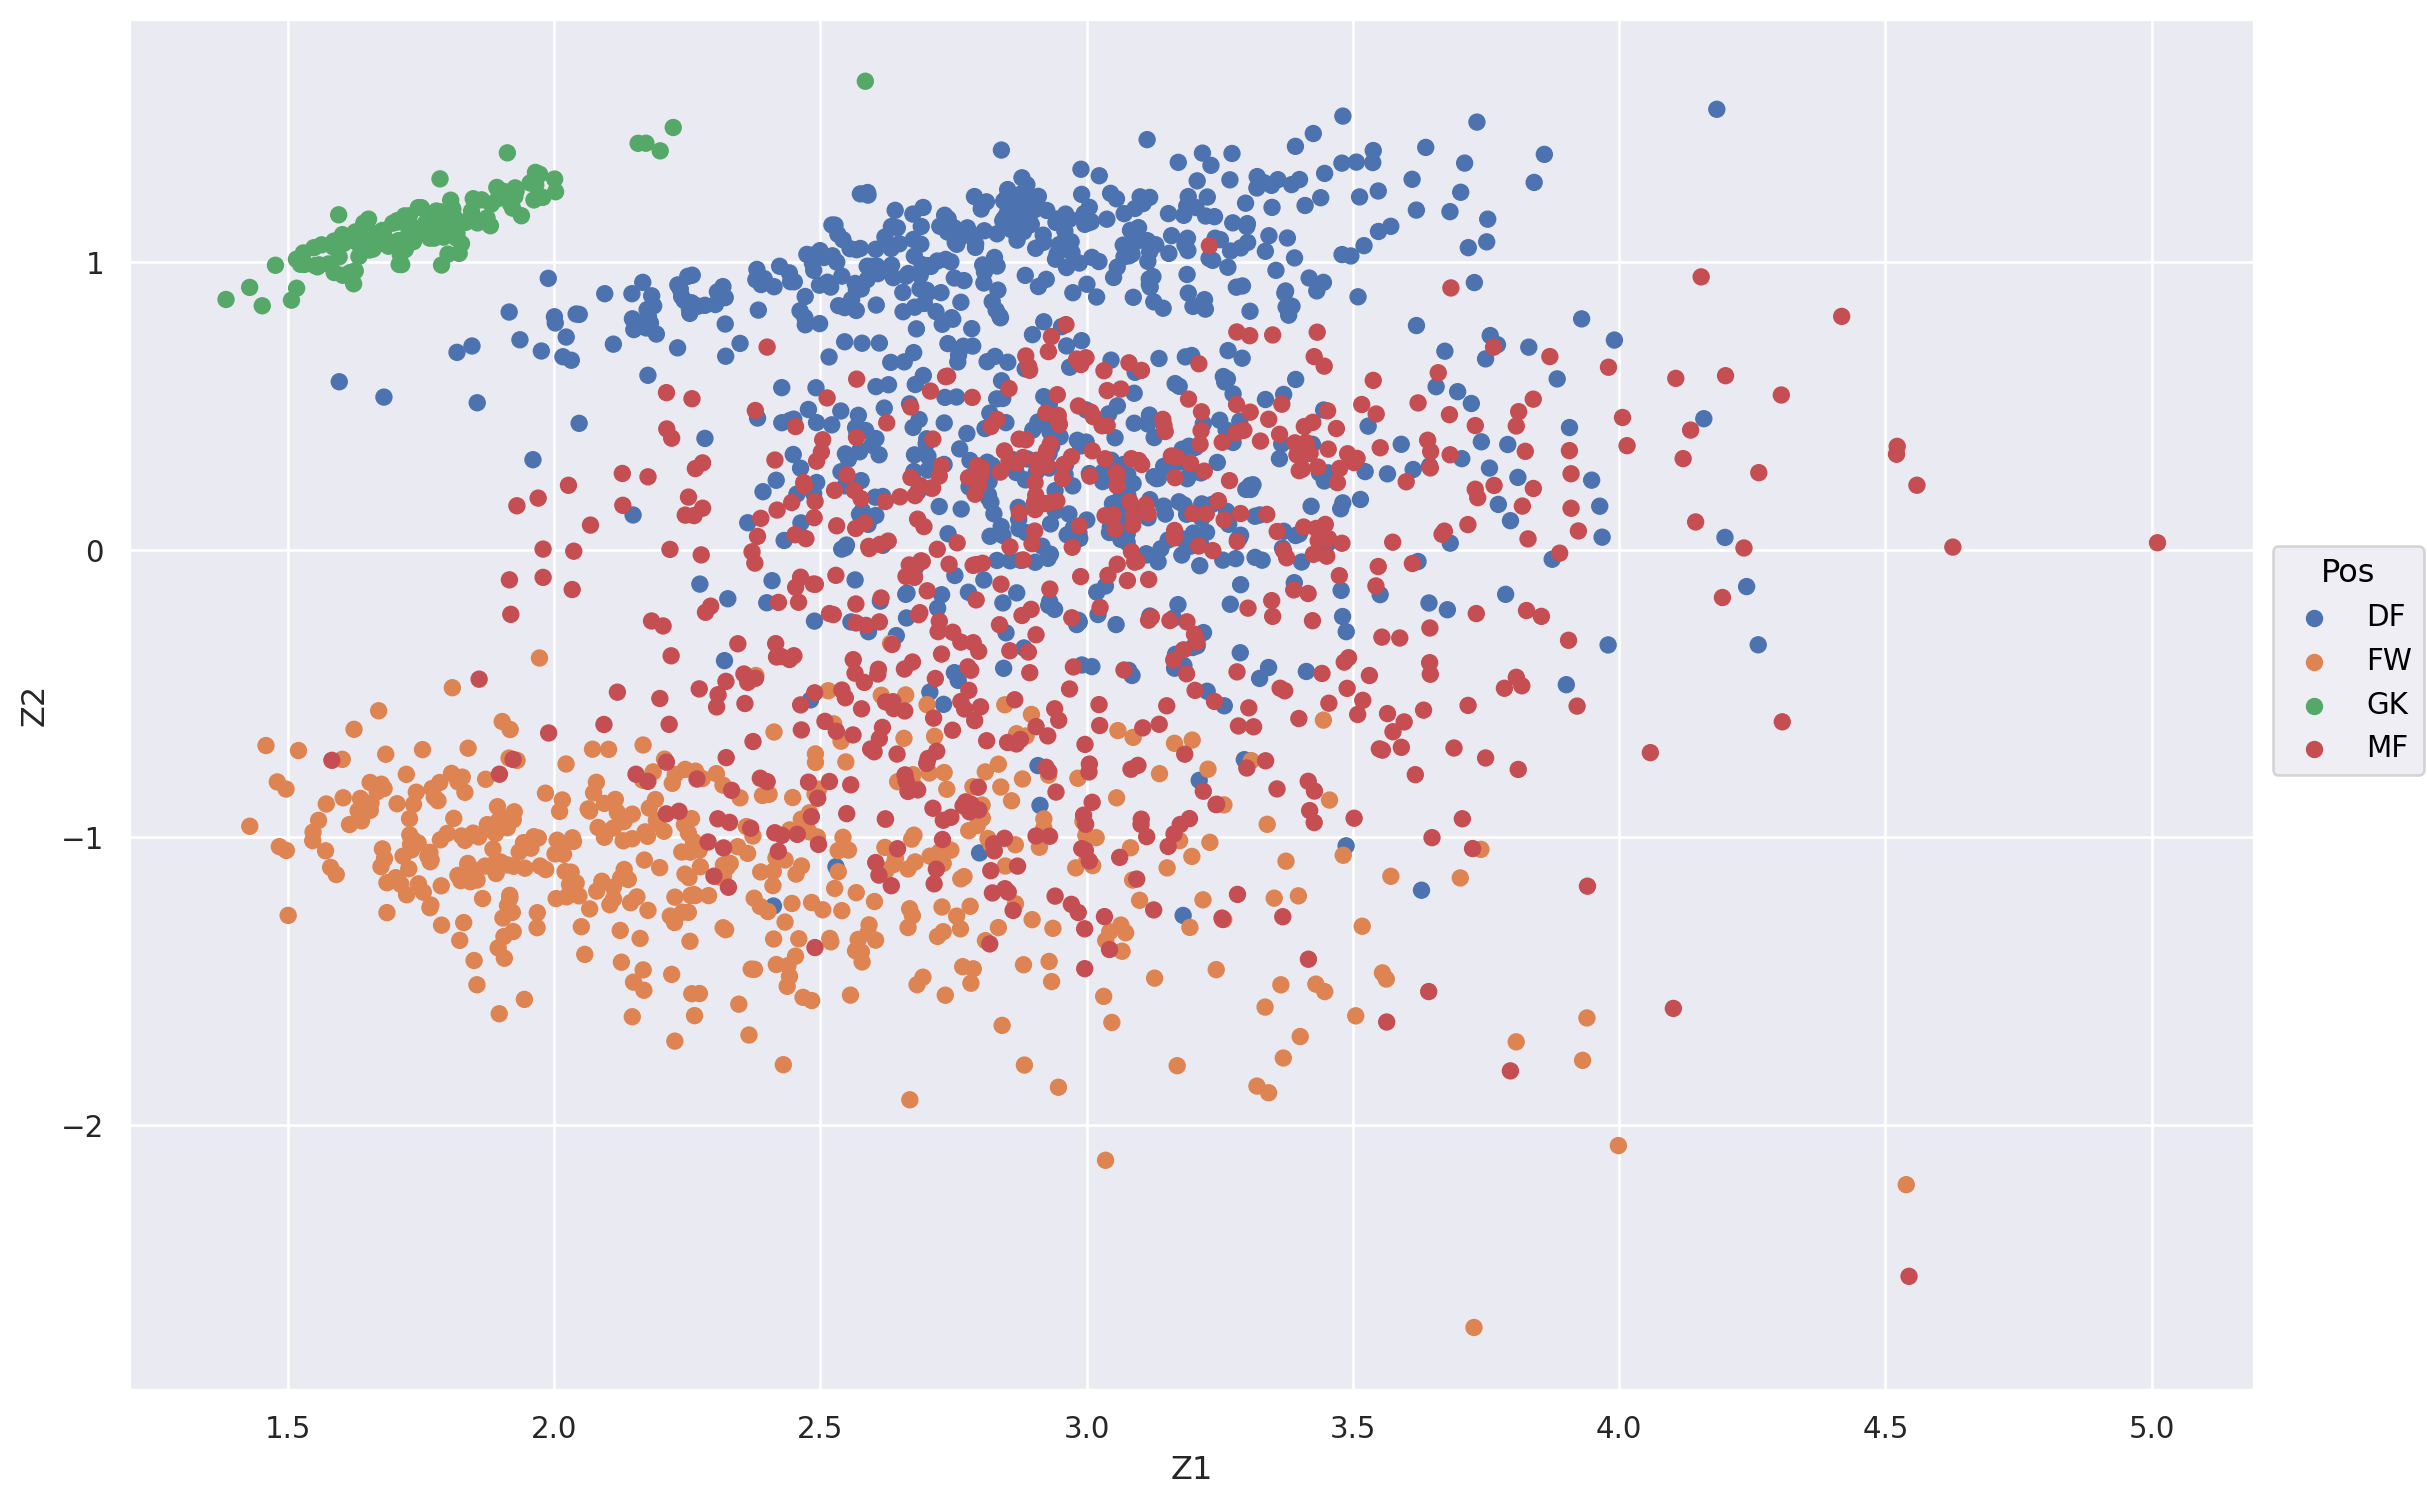

In [109]:
(
    so.Plot(data = Z, x = "Z1", y = "Z2", color = data_proc['Pos'].apply(lambda x: x.split(',')[0]))
    .add(so.Dot())
    .layout(size=(12,8))    
)

Se pueden observar cuatro clusters en el gráfico, esta división se debe a las diferencias entre las características de los jugadores por la posición que ocupan.

### KMeans

Realizamos K-Means con las primeras dos componentes principales.

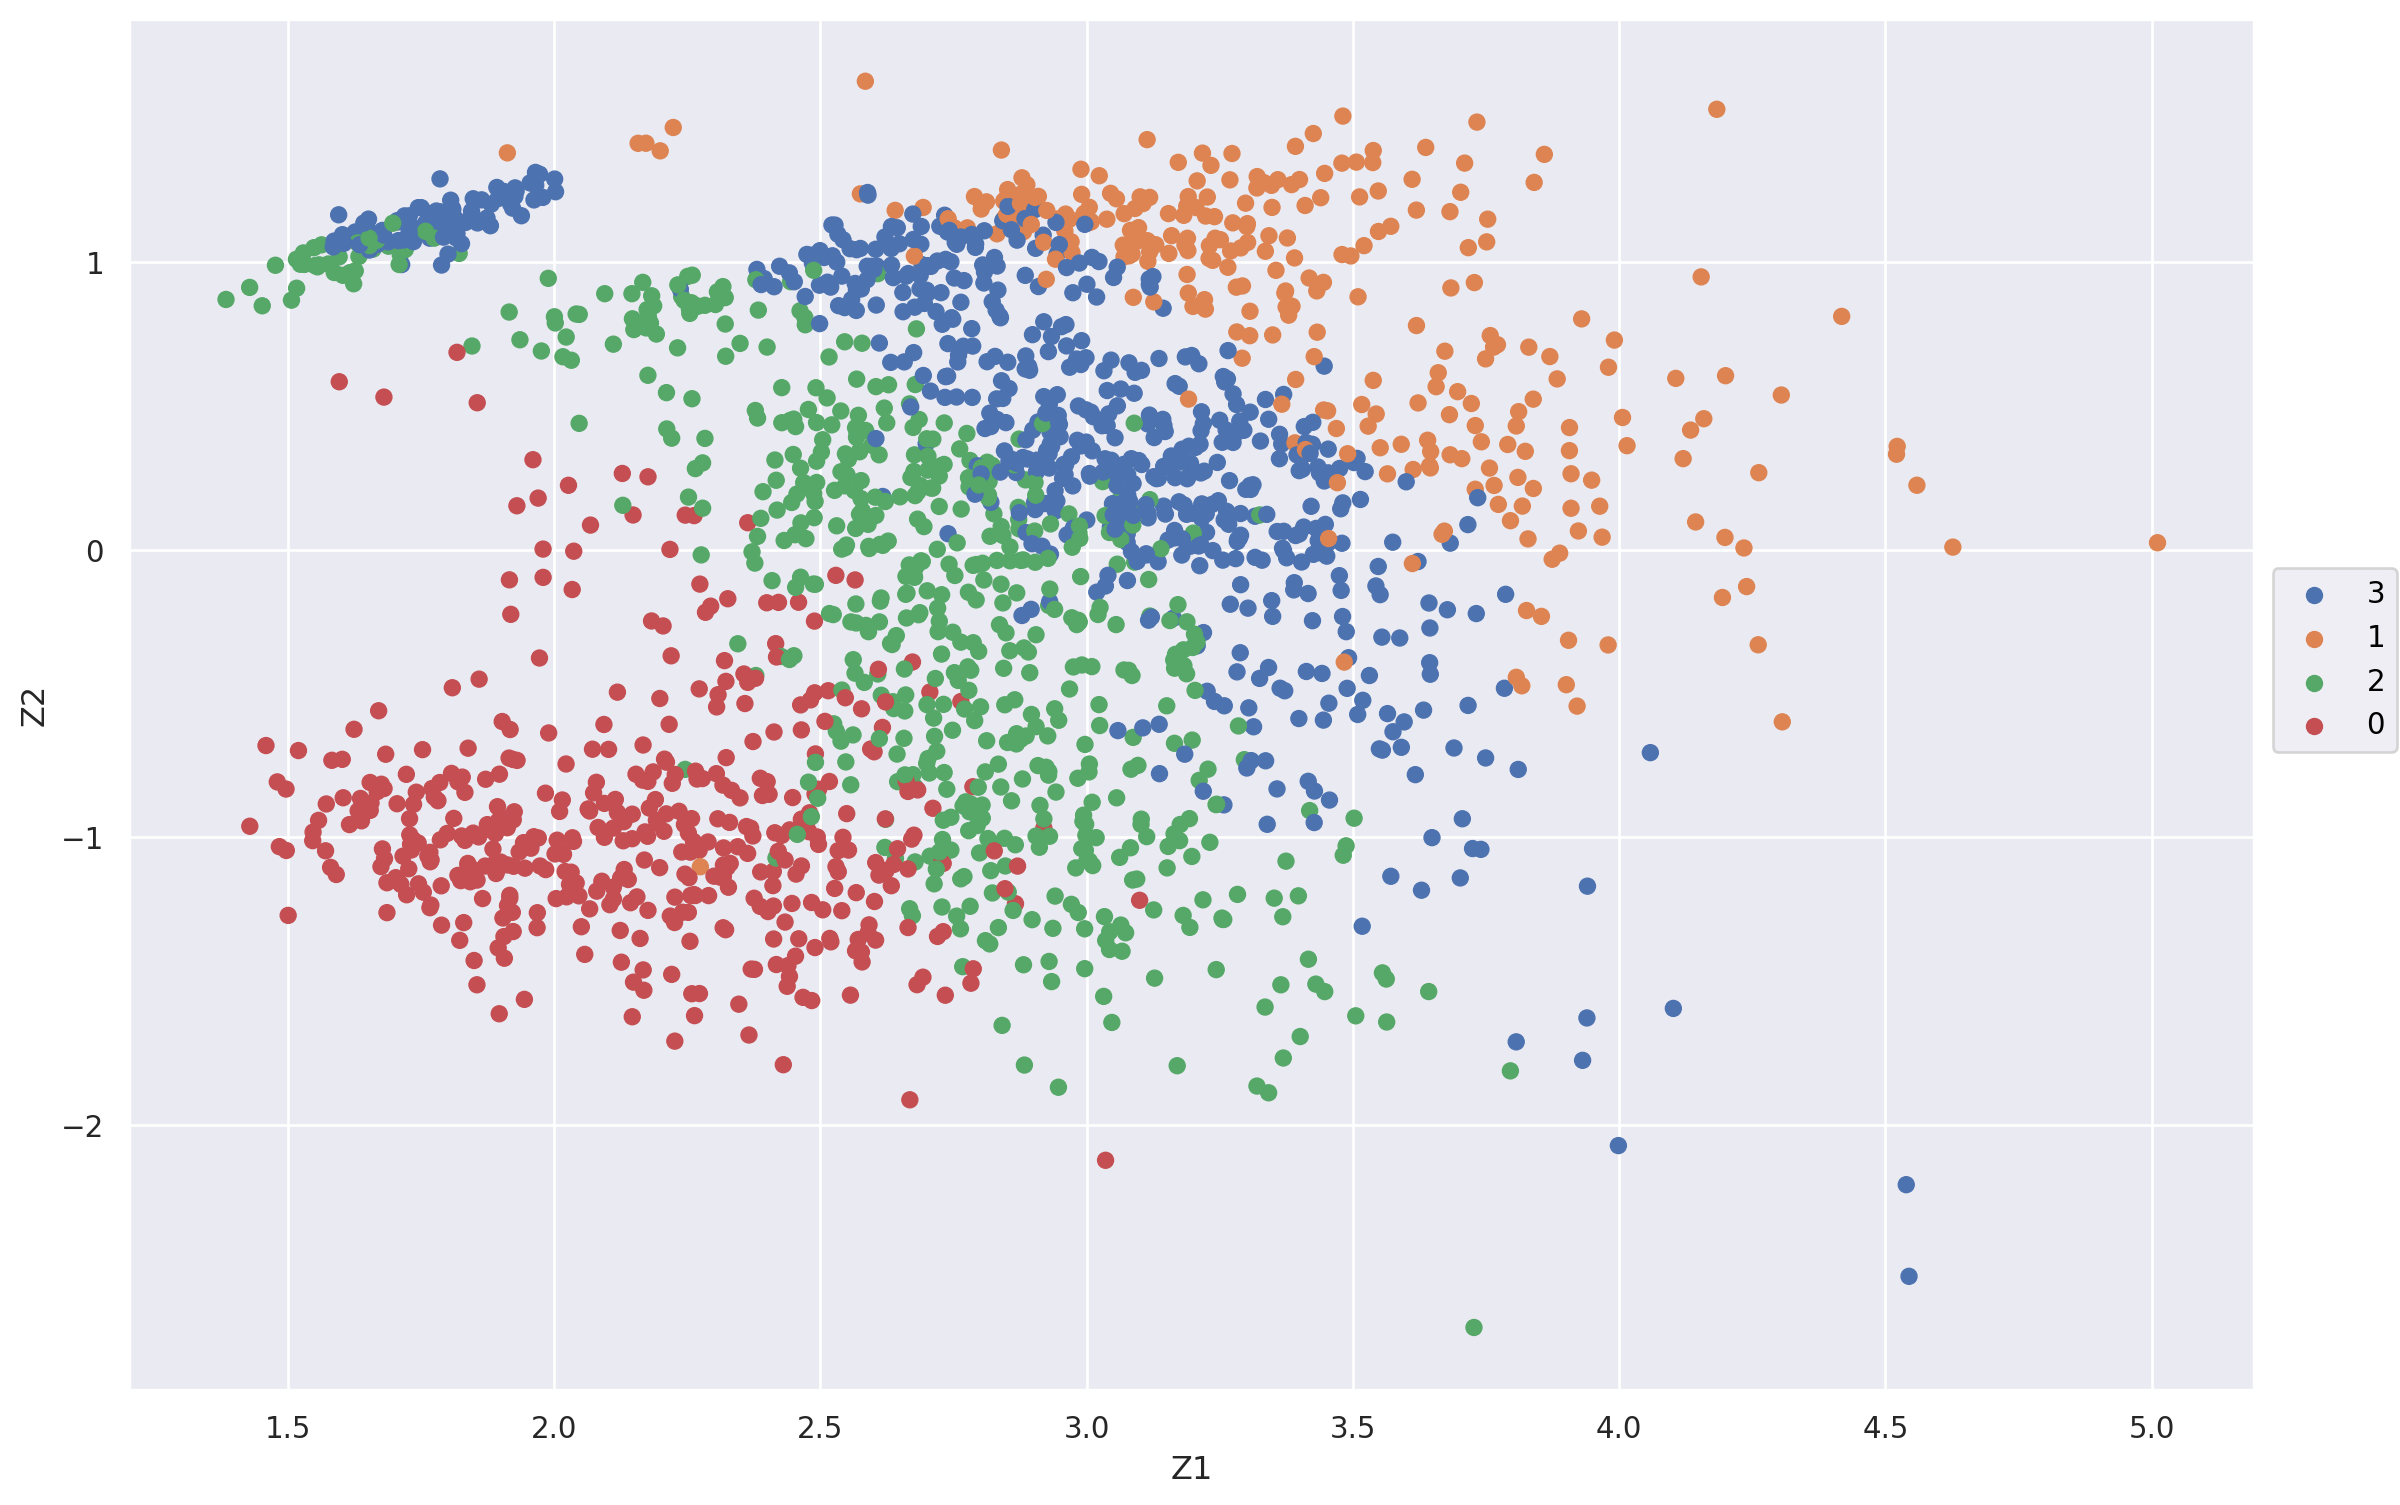

In [144]:
kmeans = KMeans (n_clusters = 4)

etiquetas = kmeans.fit_predict(data_num).astype(str)

(
    so.Plot()
    .add(so.Dot(), data = Z, x = "Z1", y = "Z2", color = etiquetas)
    .layout(size=(12,8))
)



Las divisiones no coinciden con lo esperado, ya que para el método de K-Means se precisa de clústeres de forma esférica cuyo radio desde el centro sea el mismo en todas las direcciones y los clústeres presentados en el gráfico tienen formas sin definición y son de tamaños muy distintos. Sin embargo, poseen cierta similitud con el gráfico de las posiciones de los jugadores.


### DBSCAN (Sobre PCA)

Elaboramos un gráfico para estimar el mejor épsilon para realizar DBSCAN con las primeras dos componentes principales.

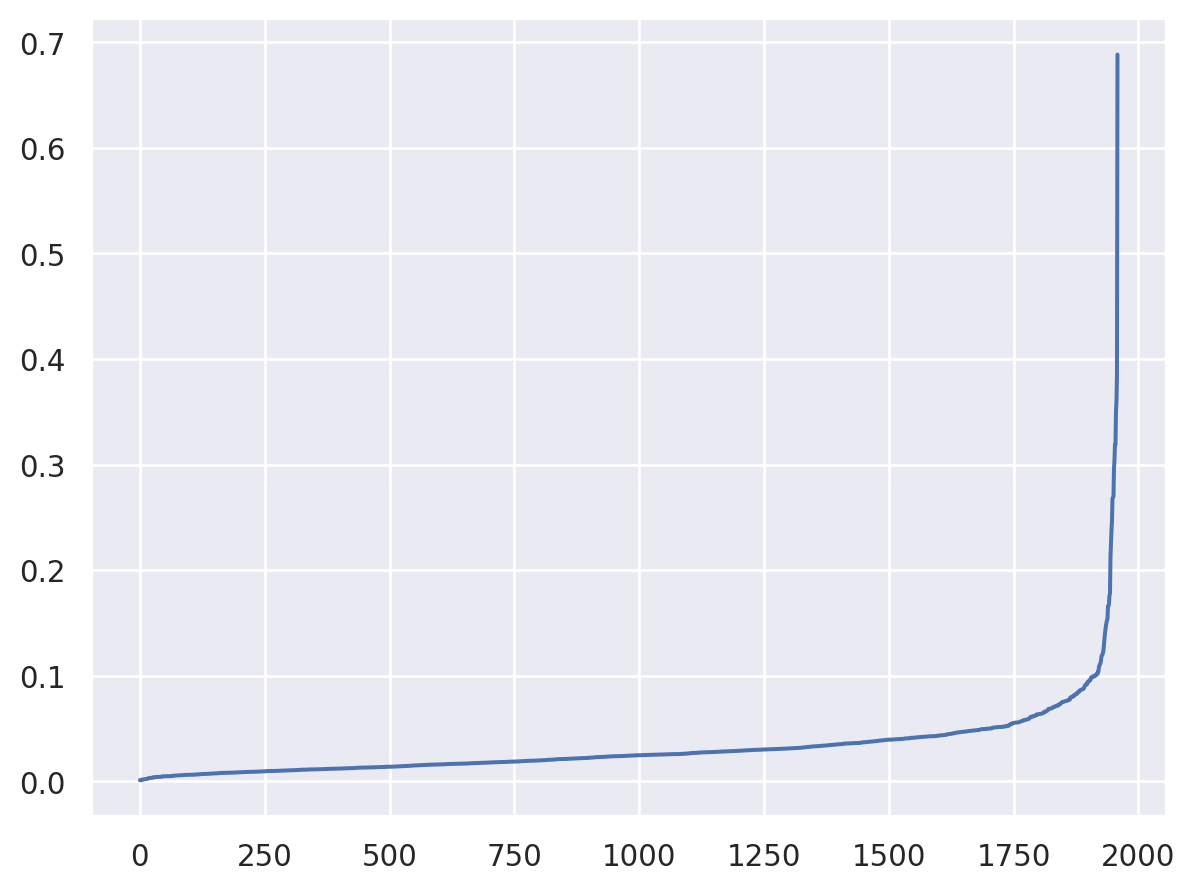

In [187]:
neighbors = NearestNeighbors(n_neighbors=2)  # Esta función nos devuelve los más cercanos incluyendo a si mismo, por eso tomamos 2.
neighbors_fit = neighbors.fit(Z.drop(columns= [col for col in Z.columns if col not in ["Z1","Z2"]]))
distances, indices = neighbors_fit.kneighbors(Z.drop(columns= [col for col in Z.columns if col not in ["Z1","Z2"]]))
distances = distances[:,1]
distances = np.sort(distances, axis=0)

so.Plot(x = np.arange(len(distances)), y = distances).add(so.Line())

Y realizamos DBSCAN, probando distintos valores de min_samples hasta hallar uno que ajuste bien los clusters esperados con la menor cantidad de outliers.

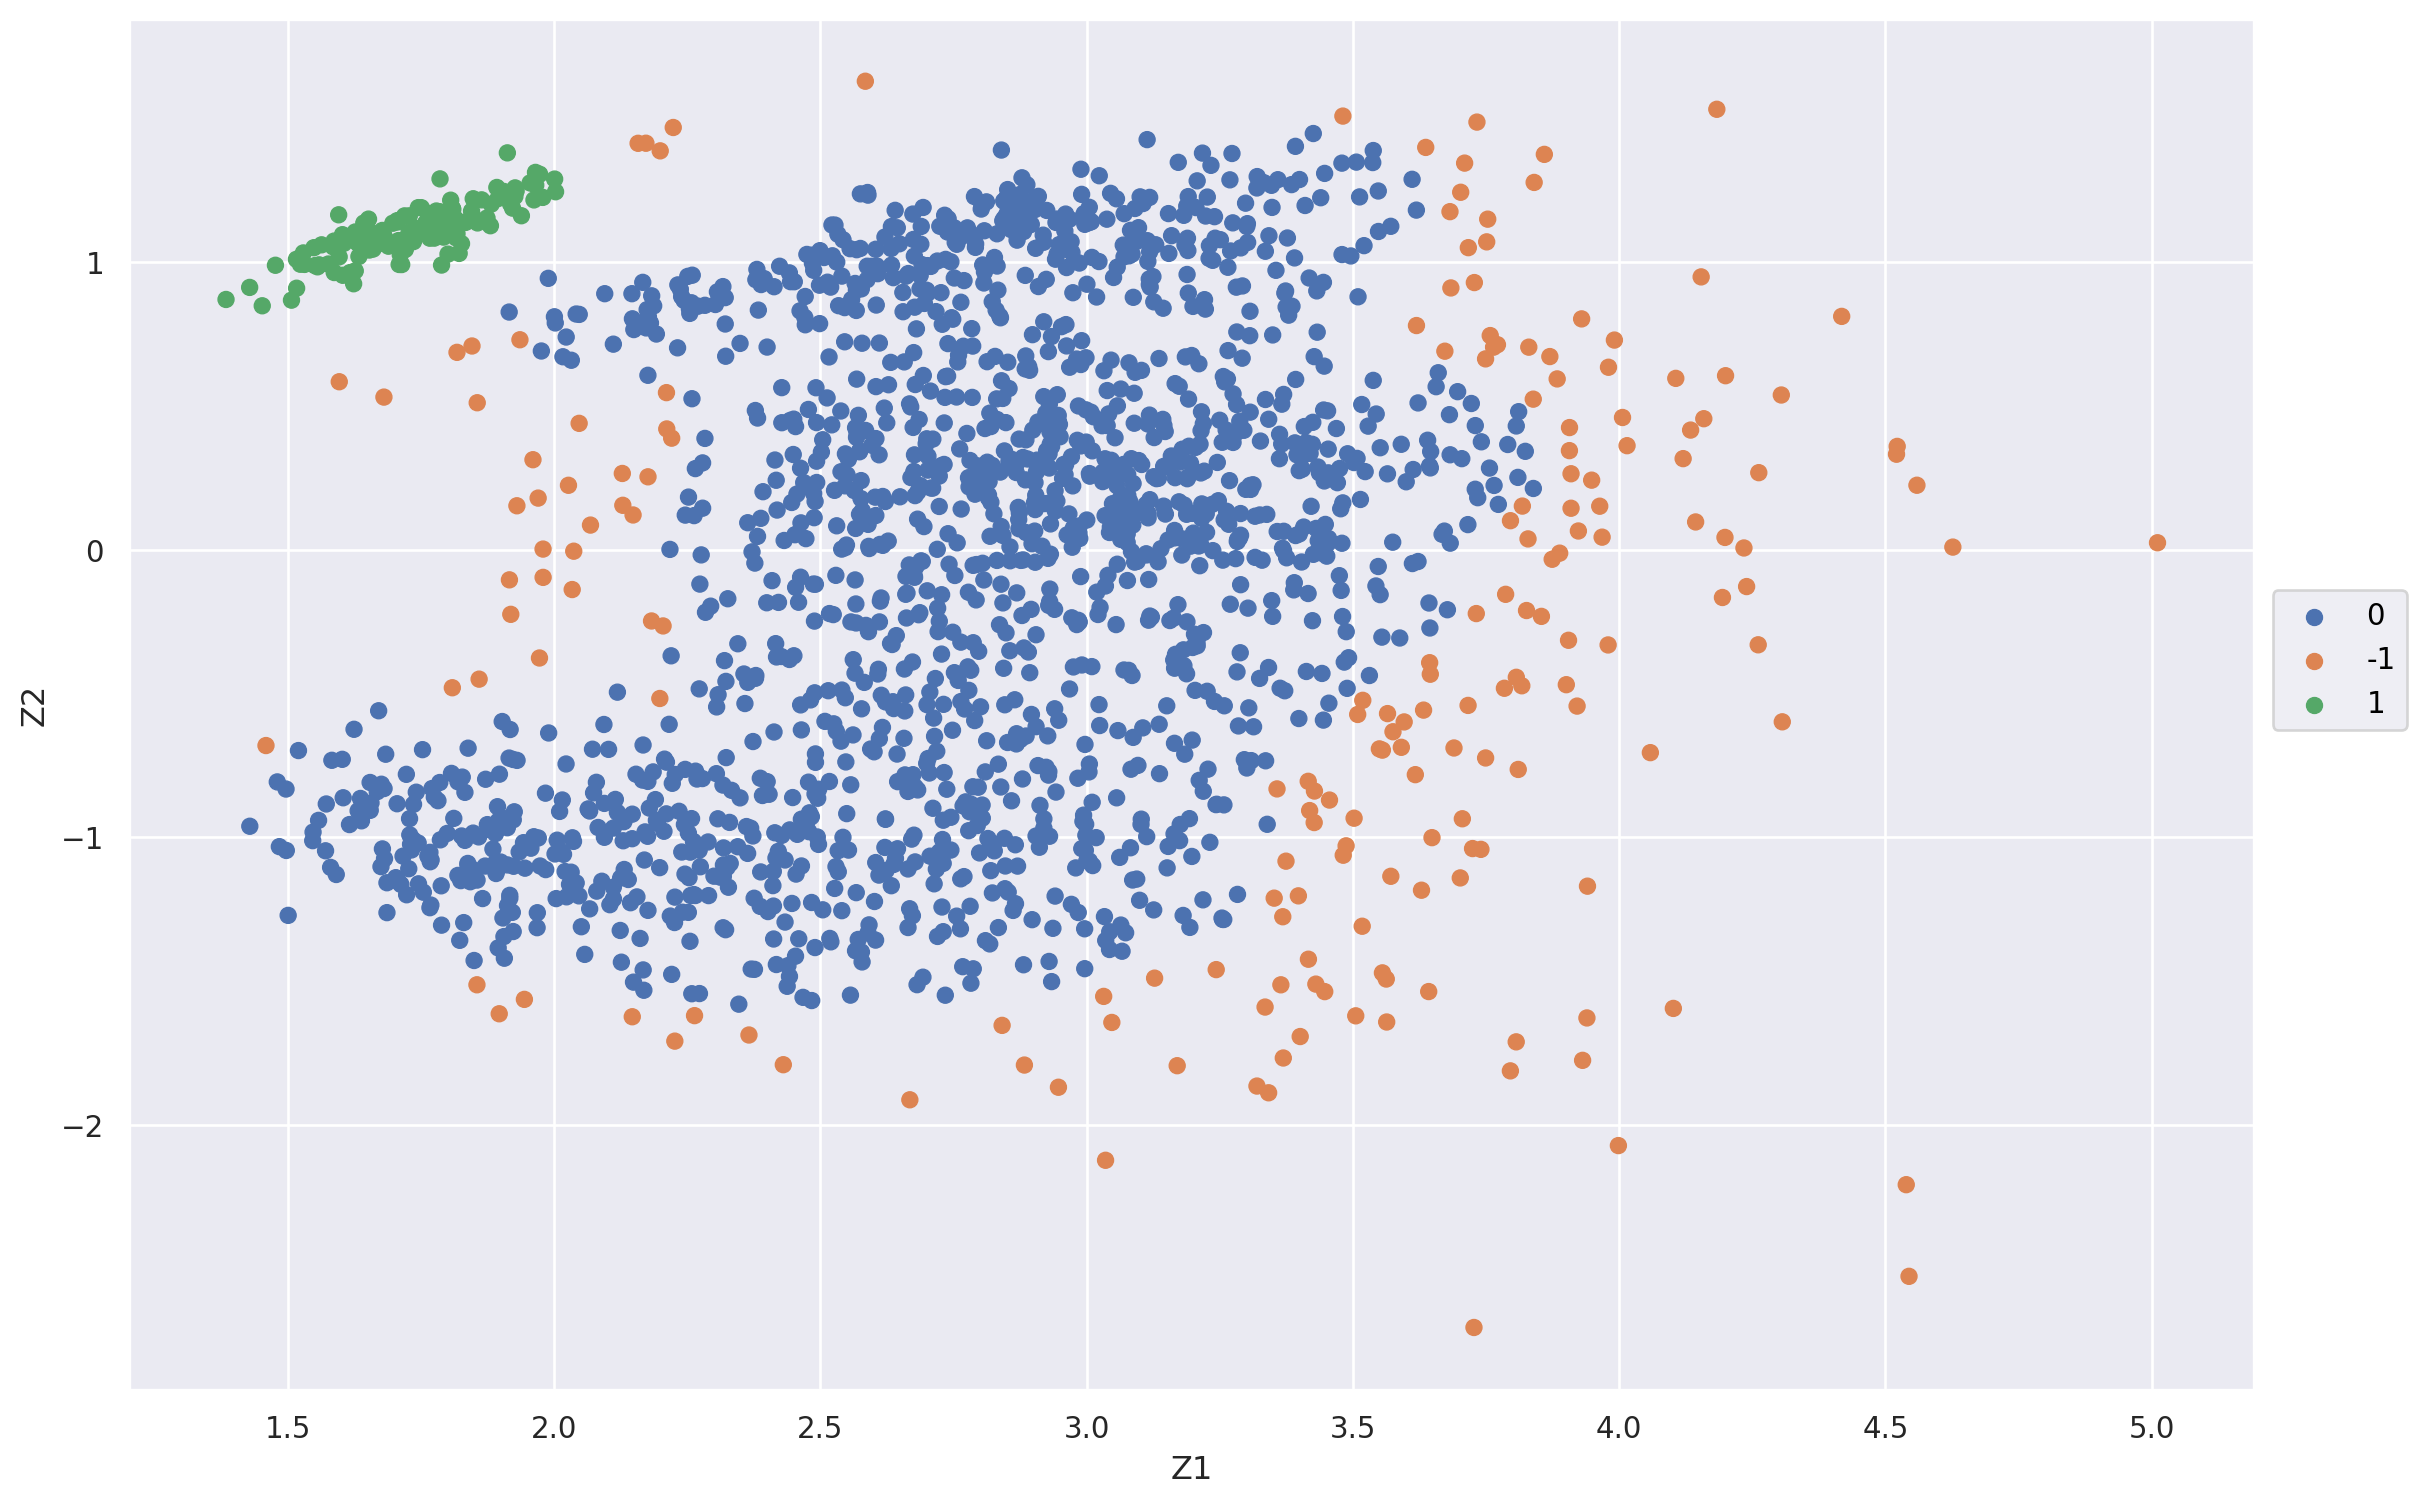

In [269]:
clustering = DBSCAN (eps= 0.2,min_samples = 30)

etiquetas = clustering.fit_predict(Z.drop(columns= [col for col in Z.columns if col not in ["Z1","Z2"]]))

(
    so.Plot(data = Z.drop(columns= [col for col in Z.columns if col not in ["Z1","Z2"]]), x = "Z1", y = "Z2", color = etiquetas.astype(str))
    .add(so.Dot())
    .layout(size=(12,8))
)


La función a continuación tiene como objetivo contar la cantidad de outliers en el clustering de DBSCAN realizado. 

In [270]:
outliers = 0

for valor in etiquetas:
    if valor == -1:
        outliers += 1

outliers

191

Eligiendo como mejor épsilon 0.2, ya que según el gráfico de más arriba el mismo está entre 0.09 y 0.1 pero con numeros inferiores a 0.2 no se dividen bien los dos clusters, y min_samples = 30, se obtuvieron 191 outliers y dos clusters bien definidos.

### DBSCAN (Sobre datos originales)

Repetimos los pasos pero esta vez usando los datos escalados en X_star en vez de las componentes principales.

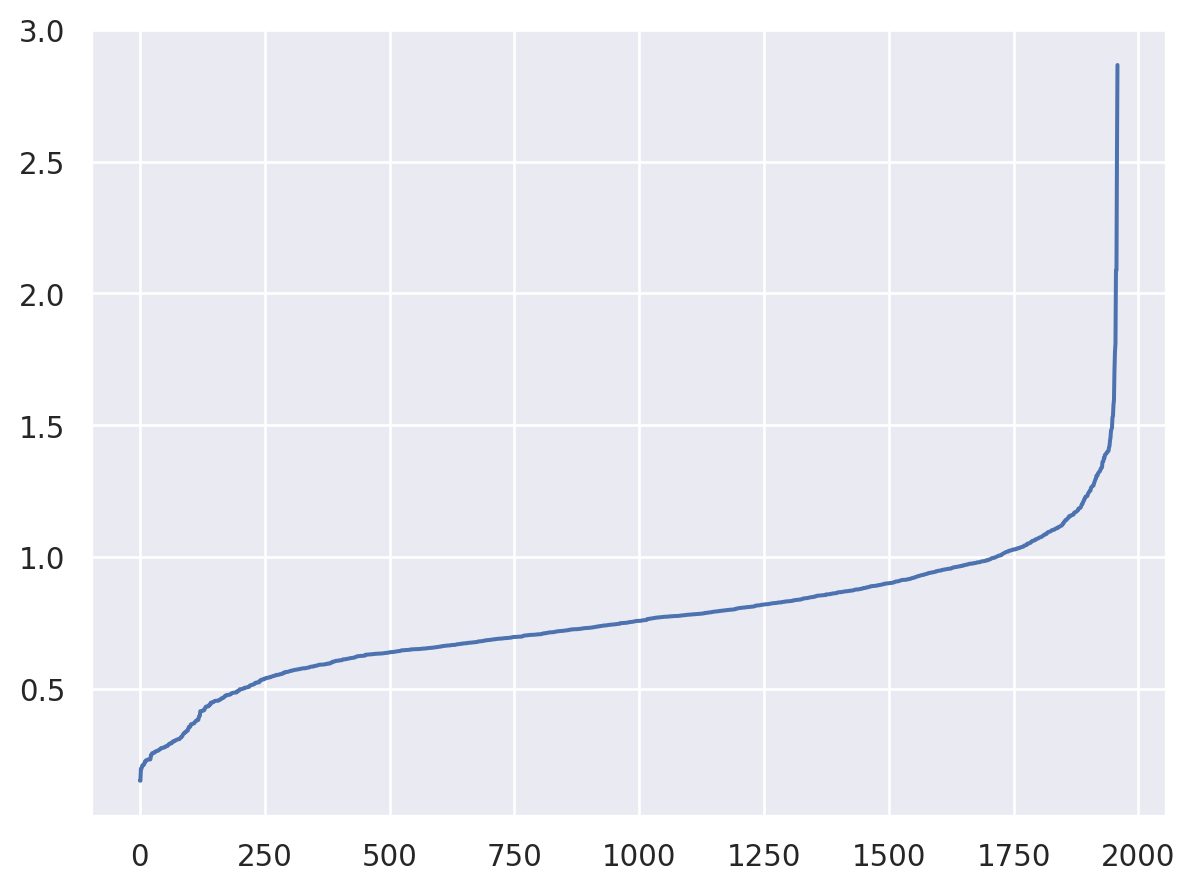

In [271]:
neighbors = NearestNeighbors(n_neighbors=2)  # Esta función nos devuelve los más cercanos incluyendo a si mismo, por eso tomamos 2.
neighbors_fit = neighbors.fit(X_star)
distances, indices = neighbors_fit.kneighbors(X_star)
distances = distances[:,1]
distances = np.sort(distances, axis=0)

so.Plot(x = np.arange(len(distances)), y = distances).add(so.Line())

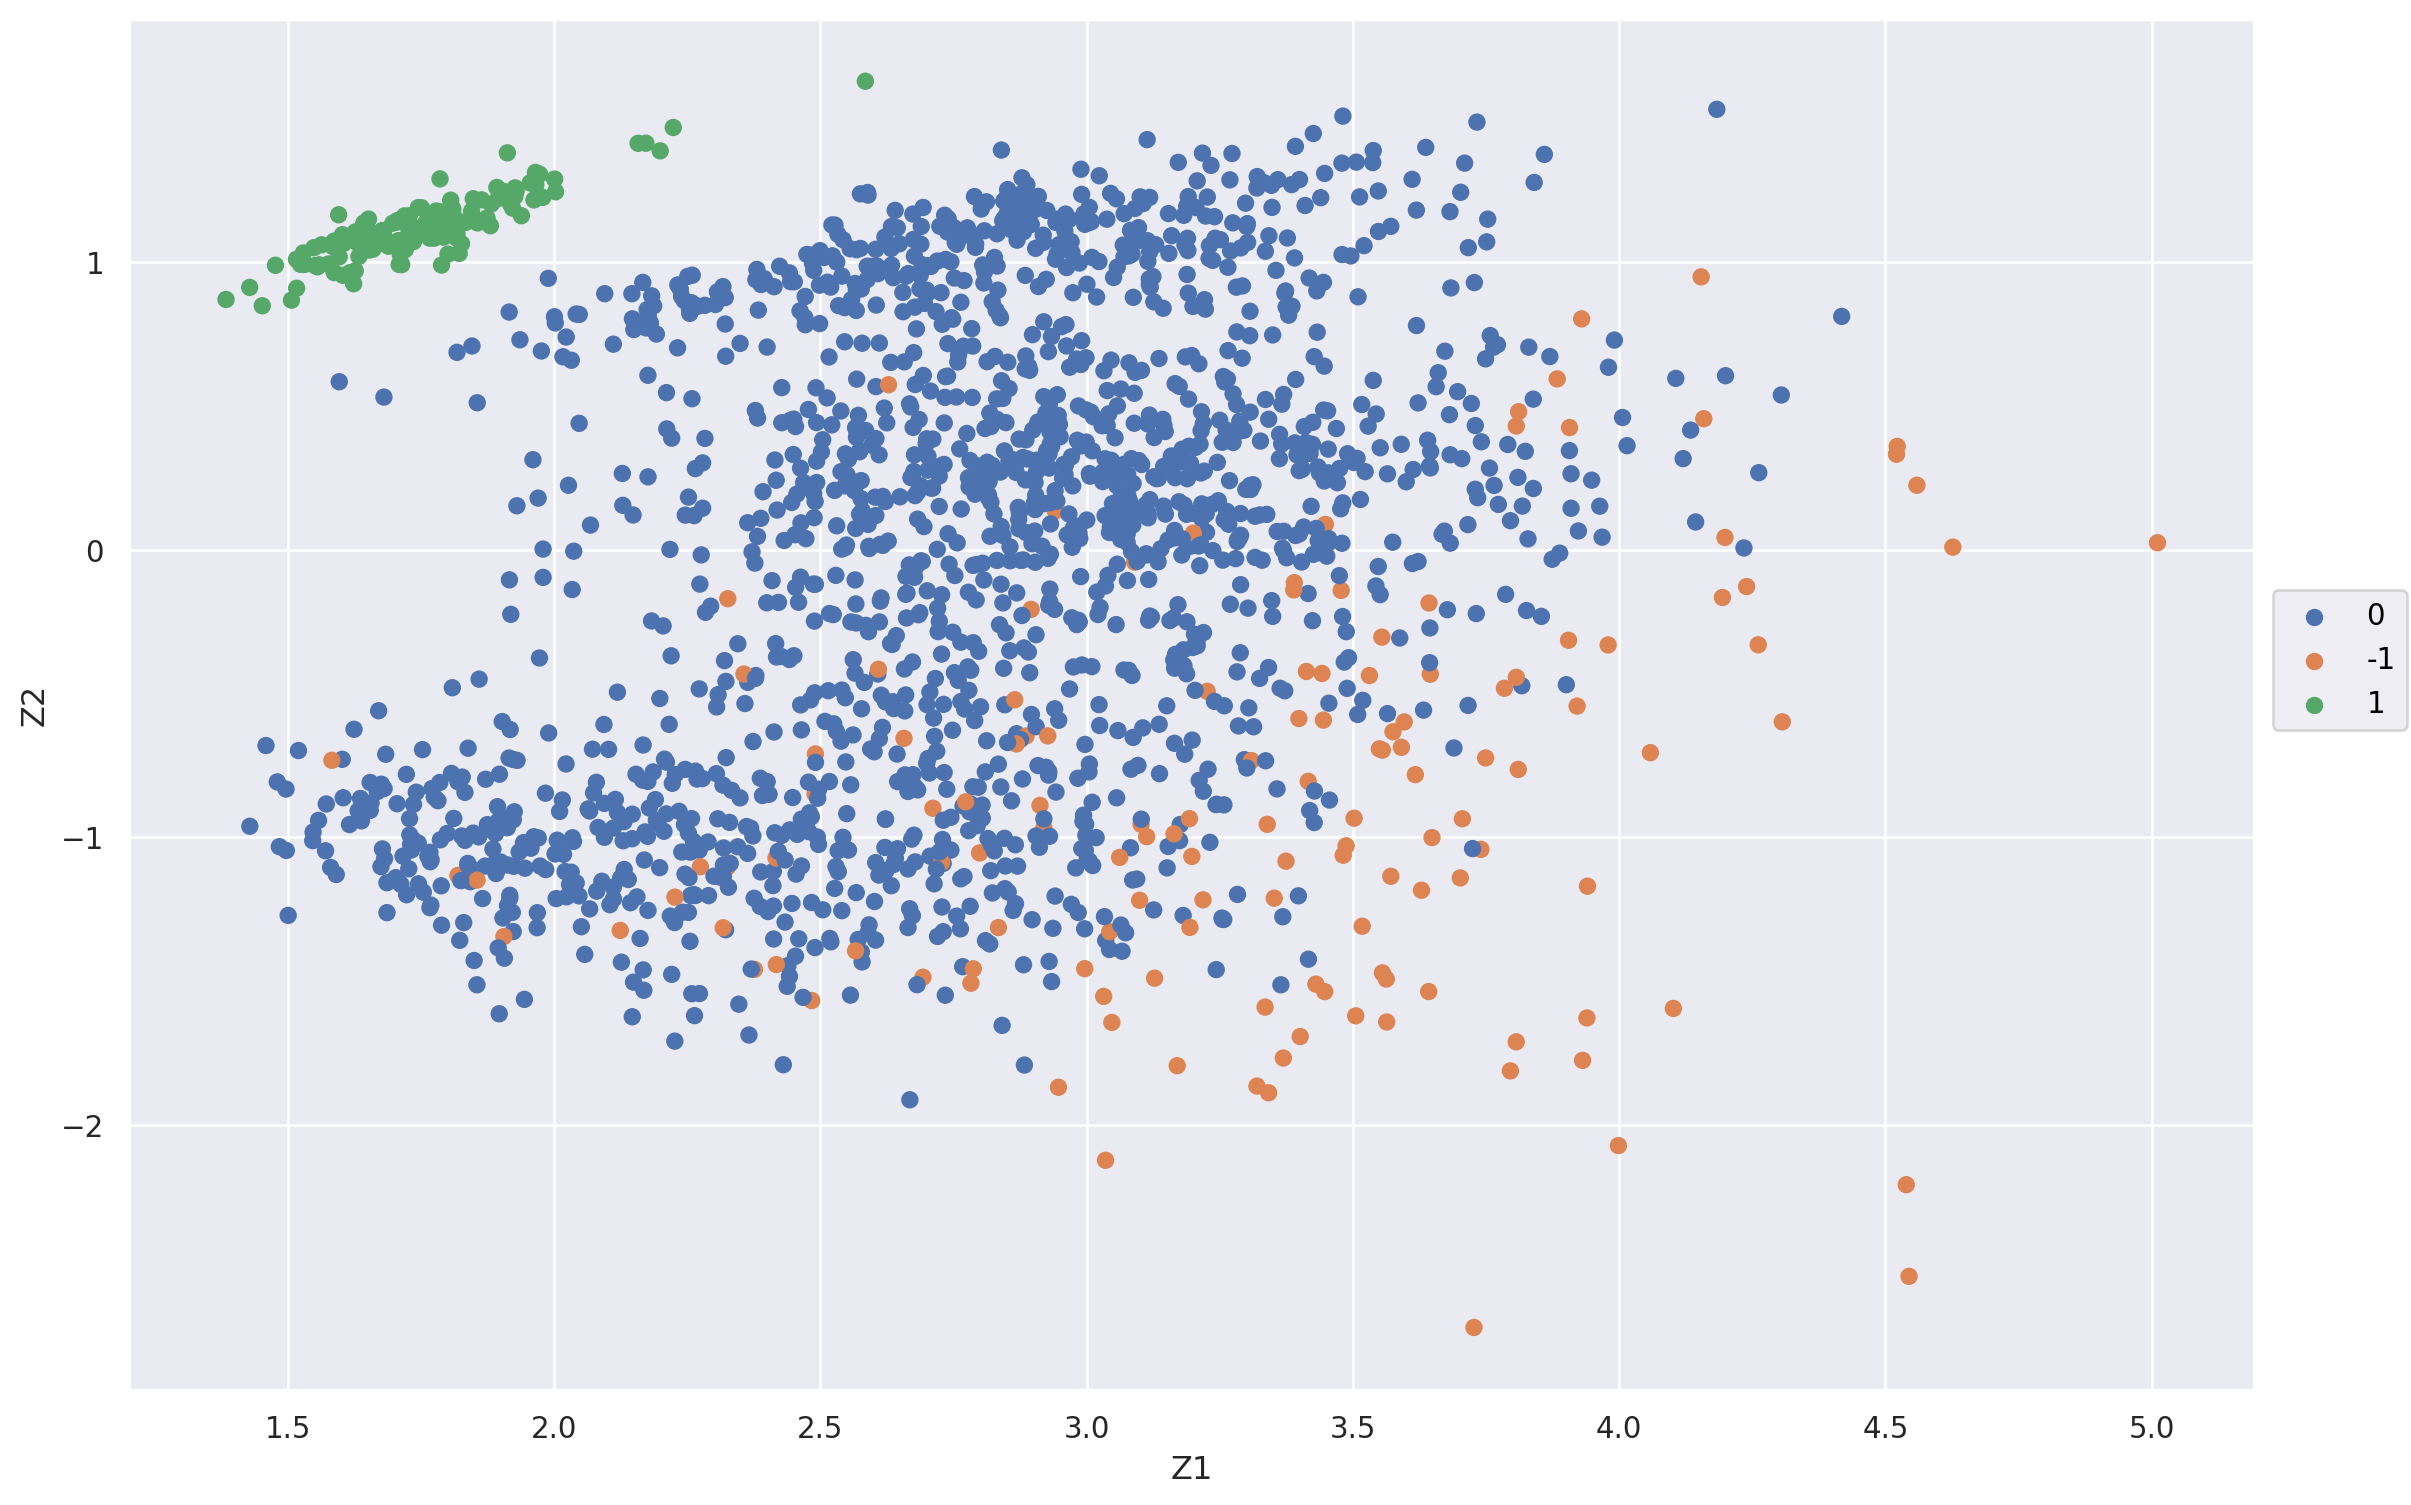

In [272]:
clustering2 = DBSCAN(eps= 1.1,min_samples = 3)

etiquetas = clustering2.fit_predict(X_star)

(
    so.Plot(data = Z.drop(columns= [col for col in Z.columns if col not in ["Z1","Z2"]]), x= "Z1", y= "Z2", color = etiquetas.astype(str))
    .add(so.Dot())
    .layout(size=(12,8))
)

In [273]:
outliers = 0

for valor in etiquetas:
    if valor == -1:
        outliers += 1

outliers

137

Eligiendo como mejor épsilon 1.1, ya que según el gráfico de más arriba el mismo está entre 0.8 y 1.1, y min_samples = 3, se obtuvieron 137 outliers y dos clusters bien definidos.

Tanto para la elección del épsilon como para la cantidad de outliers, se consiguen mejores resultados con menor trabajo utilizando los datos originales.

## Clasificación

### Primer análisis

In [60]:
data_clasif = data_proc.drop(columns = [col for col in data_proc.columns if data_proc[col].dtype not in ['float64','int64']])
data_clasif = data_clasif.drop(columns = data_num.columns.tolist()[:data_num.columns.tolist().index('Ast/90')]).join(data_proc['Pos'].apply(lambda x: x.split(',')[0])).rename(columns = {'Pos': 'Pos_filt'})

X_train, X_test, y_train, y_test = train_test_split(data_num, data_clasif['Pos_filt'], test_size=0.2, random_state=42)

clsf = GridSearchCV(estimator = KNeighborsClassifier(),param_grid={'n_neighbors':[2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20]}, cv = LeaveOneOut(), verbose=1)
clsf.fit(X_train,y_train)

Fitting 1567 folds for each of 19 candidates, totalling 29773 fits


GridSearchCV(cv=LeaveOneOut(), estimator=KNeighborsClassifier(),
             param_grid={'n_neighbors': [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,
                                         14, 15, 16, 17, 18, 19, 20]},
             verbose=1)

In [62]:
model = KNeighborsClassifier(n_neighbors = 8)
model.fit(X_train,y_train)
score = model.score(X_test, y_test)
print(score)


0.47540983606557374


Comparando este resultado con el que se obtiene luego de quedarse con las componentes principales, este es más alto, lo cual tiene sentido ya que PCA nos permite hacer que sea menos costoso el modelo, pero a costa de su precisión.

In [44]:
data_comp_princ = Z.drop(columns= Z.columns.tolist()[2:])

X_train, X_test, y_train, y_test = train_test_split(data_comp_princ, data_clasif['Pos_filt'], test_size=0.2, random_state=42)

clsf = GridSearchCV(estimator = KNeighborsClassifier(),param_grid={'n_neighbors':[2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20]}, cv = LeaveOneOut(), verbose=1)
clsf.fit(X_train,y_train)

model = KNeighborsClassifier(n_neighbors = clsf.best_params_['n_neighbors'])
model.fit(X_train,y_train)
score = model.score(X_test, y_test)
print(score)

Fitting 1567 folds for each of 19 candidates, totalling 29773 fits


GridSearchCV(cv=LeaveOneOut(), estimator=KNeighborsClassifier(),
             param_grid={'n_neighbors': [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,
                                         14, 15, 16, 17, 18, 19, 20]},
             verbose=1)

### Segundo análisis

In [15]:
data_liga_f = pd.read_csv("superleague2023.csv")
data_KNN_liga_f = data_liga_f.drop(columns = data_liga_f.columns.tolist()[:data_liga_f.columns.tolist().index('MP')]).join(data_liga_f['Pos'].apply(lambda x: x.split(',')[0])).rename(columns = {'Pos': 'Pos_filt'})
display(data_KNN_liga_f.isna().sum()) #No hace falta filtrar ningun dato vacío
display(data_KNN_liga_f)


MP                        0
Starts                    0
Min                       0
90s                       0
Performance_Gls           0
Performance_Ast           0
Performance_G+A           0
Performance_G-PK          0
Performance_PK            0
Performance_PKatt         0
Performance_CrdY          0
Performance_CrdR          0
Expected_xG               0
Expected_npxG             0
Expected_xAG              0
Expected_npxG+xAG         0
PrgC                      0
PrgP                      0
PrgR                      0
Per90Minutes_Gls          0
Per90Minutes_Ast          0
Per90Minutes_G+A          0
Per90Minutes_G-PK         0
Per90Minutes_G+A-PK       0
Per90Minutes_xG           0
Per90Minutes_xAG          0
Per90Minutes_xG+xAG       0
Per90Minutes_npxG         0
Per90Minutes_npxG+xAG     0
Pos_filt                  0
dtype: int64

,MP,Starts,Min,90s,Performance_Gls,Performance_Ast,Performance_G+A,Performance_G-PK,Performance_PK,Performance_PKatt,...,Per90Minutes_Ast,Per90Minutes_G+A,Per90Minutes_G-PK,Per90Minutes_G+A-PK,Per90Minutes_xG,Per90Minutes_xAG,Per90Minutes_xG+xAG,Per90Minutes_npxG,Per90Minutes_npxG+xAG,Pos_filt
0,11,0,87,1.0,0,1,1,0,0,0,...,1.03,1.03,0.0,1.03,0.03,0.00,0.03,0.03,0.03,MF
1,1,0,6,0.1,0,0,0,0,0,0,...,0.00,0.00,0.0,0.00,0.00,0.00,0.00,0.00,0.00,FW
2,1,0,1,0.0,0,0,0,0,0,0,...,0.00,0.00,0.0,0.00,0.00,0.00,0.00,0.00,0.00,MF
3,16,10,923,10.3,1,2,3,1,0,0,...,0.20,0.29,0.1,0.29,0.04,0.12,0.15,0.04,0.15,MF
4,6,4,296,3.3,0,0,0,0,0,0,...,0.00,0.00,0.0,0.00,0.06,0.00,0.06,0.06,0.06,DF
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
299,2,1,118,1.3,0,0,0,0,0,0,...,0.00,0.00,0.0,0.00,0.00,0.00,0.00,0.00,0.00,DF
300,22,22,"1,980",22.0,1,6,7,0,1,1,...,0.27,0.32,0.0,0.27,0.07,0.27,0.34,0.04,0.30,MF
301,20,18,"1,568",17.4,0,1,1,0,0,0,...,0.06,0.06,0.0,0.06,0.03,0.06,0.09,0.03,0.09,MF
302,18,18,"1,620",18.0,0,0,0,0,0,0,...,0.00,0.00,0.0,0.00,0.00,0.00,0.00,0.00,0.00,GK


In [16]:
data_KNN_liga_f['Min'] = data_KNN_liga_f['Min'].str.replace(',','').apply(int)

X_train, X_test, y_train, y_test = train_test_split(data_KNN_liga_f.drop(columns='Pos_filt'), data_KNN_liga_f['Pos_filt'], test_size=0.2, random_state=69)

model = KNeighborsClassifier(n_neighbors = clsf.best_params_['n_neighbors'])
model.fit(X_train,y_train)
score = model.score(X_test, y_test)
print(score)

0.4426229508196721


Vamos que el predictor es mucho peor para este conjunto de datos, tratemos de ver si hay algún numero mejor para K.

In [63]:
X_train, X_test, y_train, y_test = train_test_split(data_KNN_liga_f.drop(columns='Pos_filt'), data_KNN_liga_f['Pos_filt'], test_size=0.2, random_state=69)

clsf = GridSearchCV(estimator = KNeighborsClassifier(),param_grid={'n_neighbors':[2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20]}, cv = LeaveOneOut(), verbose=1)
clsf.fit(X_train,y_train)

model = KNeighborsClassifier(n_neighbors = clsf.best_params_['n_neighbors'])
model.fit(X_train,y_train)
score = model.score(X_test, y_test)
print(score)

Fitting 243 folds for each of 19 candidates, totalling 4617 fits
0.4426229508196721


Vemos que el modelo sigue performando peor. Intentemos ahora usar PCA para reducir un poco la dimensionalidad (puede que estemos cayendo en la "maldición de la dimensionalidad" con este dataset).


In [28]:
pca_liga_f = PCA(n_components=5)
Z_liga_f = pca_liga_f.fit_transform(data_KNN_liga_f.drop(columns='Pos_filt'))

X_train, X_test, y_train, y_test = train_test_split(Z_liga_f, data_KNN_liga_f['Pos_filt'], test_size=0.2, random_state=808017424)

clsf = GridSearchCV(estimator = KNeighborsClassifier(),param_grid={'n_neighbors':[2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20]}, cv = LeaveOneOut(), verbose=1)
clsf.fit(X_train,y_train)

model = KNeighborsClassifier(n_neighbors = clsf.best_params_['n_neighbors'])
model.fit(X_train,y_train)
score = model.score(X_test, y_test)

print(score)

Fitting 243 folds for each of 19 candidates, totalling 4617 fits


GridSearchCV(cv=LeaveOneOut(), estimator=KNeighborsClassifier(),
             param_grid={'n_neighbors': [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,
                                         14, 15, 16, 17, 18, 19, 20]},
             verbose=1)

No parece que esto mejore de ninguna foroma la performance del modelo. Intentemos eliminar los datos de jugadores con pocos minutos de juego.

In [22]:
liga_f_500 = data_KNN_liga_f[data_KNN_liga_f['Min'] >= 500]

X_train, X_test, y_train, y_test = train_test_split(liga_f_500.drop(columns='Pos_filt'), liga_f_500['Pos_filt'], test_size=0.2, random_state=808017424)

clsf = GridSearchCV(estimator = KNeighborsClassifier(),param_grid={'n_neighbors':[2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20]}, cv = LeaveOneOut(), verbose=1)
clsf.fit(X_train,y_train)

model = KNeighborsClassifier(n_neighbors = clsf.best_params_['n_neighbors'])
model.fit(X_train,y_train)
score = model.score(X_test, y_test)

print(score)

Fitting 160 folds for each of 19 candidates, totalling 3040 fits
0.4146341463414634


Sigue sin mejorar. Es mejor tirar una moneda para adivinar la posición del jugador.

## Predicciones de jugadores

In [24]:
data = pd.read_csv ("transfermarkt_fbref_201920.csv", delimiter =";")

data_num_players = data.drop(columns = [col for col in data.columns if (data[col].dtype not in ['float64','int64']) & (col != "player")])
display(data_num_players.head())


data = data_num_players.dropna()
data_num = data.drop(columns = [col for col in data.columns if (col == "player") | 
                                         (col == "birth_year") | (col == "Column1") | (col == "value")])
data = data.query("minutes >= 500")
data_num = data_num.query("minutes >= 500")


,Column1,player,age,birth_year,value,height,games,games_starts,minutes,goals,...,GDiff,Pts,Pts/G,xG,xGA,xGDiff,xGDiff/90,CL,WinCL,CLBestScorer
0,21,Martin Aguirregabiria,23,1996,4000000,178,31,23,2099,1,...,-25,39,1.03,37.0,53.2,-16.2,-0.43,0,0,0.0
1,390,Oliver Burke,22,1997,4000000,188,31,14,1429,1,...,-25,39,1.03,37.0,53.2,-16.2,-0.43,0,0,0.0
2,430,Ví­ctor Camarasa,25,1994,4000000,183,17,15,1293,0,...,-25,39,1.03,37.0,53.2,-16.2,-0.43,0,0,0.0
3,737,Rubén Duarte,23,1995,4000000,172,31,30,2663,0,...,-25,39,1.03,37.0,53.2,-16.2,-0.43,0,0,0.0
4,770,Rodrigo Ely,25,1993,1000000,188,25,24,2121,2,...,-25,39,1.03,37.0,53.2,-16.2,-0.43,0,0,0.0


In [32]:
Nneigh = NearestNeighbors(n_neighbors=20).fit(data_num)
Cercanía_a_Messi, indices = Nneigh.kneighbors(data_num[data['player']=='Lionel Messi'])

for indice in indices:
    print(data.iloc[indice]['player'])

[[ 186  508 1031  965  971  956 1045 1353  182  155  930  145 1043  424
  1062 1405  180  958  183  154]]
257          Lionel Messi
144            Papu Gómez
1544       Theo Hernández
1696      Piotr Zieliński
685         Achraf Hakimi
1238         José Campaña
1215         Ben Chilwell
950        Sofyan Amrabat
113         Jack Grealish
1129         Luis Alberto
278       Alphonso Davies
2163      Bastian Oczipka
2193      Sergio Reguilón
1679      Lorenzo Insigne
1815       Jamilu Collins
684     Raphaël Guerreiro
1095          Alex Sandro
1532      Ismaël Bennacer
301        Sergio Canales
1228      Ricardo Pereira
Name: player, dtype: object
257    112000000
Name: value, dtype: int64


In [260]:
X, y = data_num, data["value"]
alphas = np.arange(0,20,0.1)

Param_Grid = {"alpha": alphas}
h = GridSearchCV(linear_model.Ridge(fit_intercept = True),param_grid= Param_Grid,cv=5,scoring="r2",return_train_score= True,verbose= True,error_score='raise')

scal = MinMaxScaler((0,1))
X_scal = scal.fit_transform(X)
y_scal = scal.fit_transform(pd.DataFrame(y))

X_train, X_test, y_train, y_test = train_test_split(X_scal, y, test_size=0.2, random_state=23)

h.fit(X_train,y_train)

modeloRidge = linear_model.Ridge(alpha = 4.2, fit_intercept = True)

modeloRidge.fit(X_train, y_train)

y_pred = modeloRidge.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))


#print(f'Mejor r2: {h.best_score_}')
print(f'Mejor alpha: {h.best_estimator_}')
print(f'r2: {modeloRidge.score(X_test, y_test)}')
print(f'rmse: {rmse}')

Fitting 5 folds for each of 200 candidates, totalling 1000 fits
Mejor alpha: Ridge(alpha=4.2)
r2: 0.5887214562761967
rmse: 13333931.120902672
